<hr style="border-width:2px;border-color:#75DFC1">
<center><h1>DLMI Kaggle challenge</h1></center>
<center>Maxime RIGHINI, Nicolas GREVET</center>
<center><h2>Part 1 - Data exploration and visualization</h2></center>
<hr style="border-width:2px;border-color:#75DFC1">


Before jumping headlong into complex deep learning models, it is important to explore the data that is available to us so that we know it well.

In the case of this challenge, this step is one of the most important since we have very unusual data: huge gigapixel images.

> The structure of this notebook is as follows: 
>> I - [Imports](#imports)
>>
>>
>> II - [Plots on the available data](#plots)
>>
>>
>> III - [Visualization of the slides (+ masks)](#visualization)
>>
>>
>> IV - [Explanation of the image preprocessing pipeline](#preprocessing)
>>> A - [Background removal](#background)
>>>
>>>
>>> B - [Tile selection](#selection)
>>>
>>>
>>> C - [Test of the pipeline](#test)
>>>> 1 - [Smallest slide](#small)
>>>>
>>>>
>>>> 2 - [Biggest slide](#big)

# I - <a name="imports"></a> Imports

We start by importing the libraries that we will need throughout the notebook.

In [ ]:
!pip install -q openslide-python
!sudo apt update && apt install -q openslide-tools
!pip install -q imagecodecs
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download mvadlmi
! unzip mvadlmi.zip

In [2]:
import numpy as np
import pandas as pd
import os
import skimage.io
import openslide
import cv2
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# II - <a name="plots"></a> Plots on the available data

The purpose of this part is to use plots to learn a little more about the data.

In [3]:
df_train = pd.read_csv("train.csv").reset_index(drop=True)
df_test = pd.read_csv("test.csv").reset_index(drop=True)
print("{} rows and {} columns for the train set".format(df_train.shape[0], df_train.shape[1]))
print("{} rows and {} columns for the test set".format(df_test.shape[0], df_test.shape[1]))

340 rows and 4 columns for the train set
86 rows and 2 columns for the test set


In [4]:
df_train.head()

,image_id,data_provider,isup_grade,gleason_score
0,995df9b93db1e396b57692c6c7f1d673,radboud,0,negative
1,86d4621be3deca4f8d461e3abce7d585,radboud,4,4+4
2,e2578d331ae6cb3bc649027498c8ff8d,radboud,1,3+3
3,c65fcde885b4f231d03cefb0fc75f4fa,radboud,4,4+4
4,c4bbe05f5d77f1a42bc95191285ab1bb,radboud,3,4+3


As explained in the challenge guidelines, we have two data providers (radboud and karolinska) and 6 values for the label (isup_grade 0 -> 5).

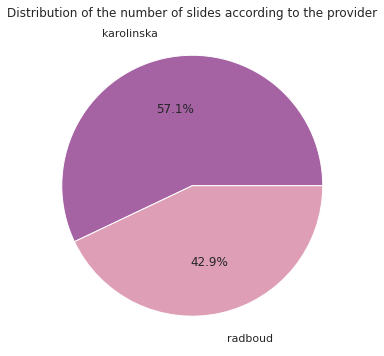

In [5]:
plt.figure(figsize=(6, 6))
plt.pie(x=df_train["data_provider"].value_counts().values,
        labels=df_train["data_provider"].value_counts().index,
        autopct="%1.1f%%",
        labeldistance=1.2,
        colors=["#a563a4", "#dd9eb6"])
plt.title("Distribution of the number of slides according to the provider");

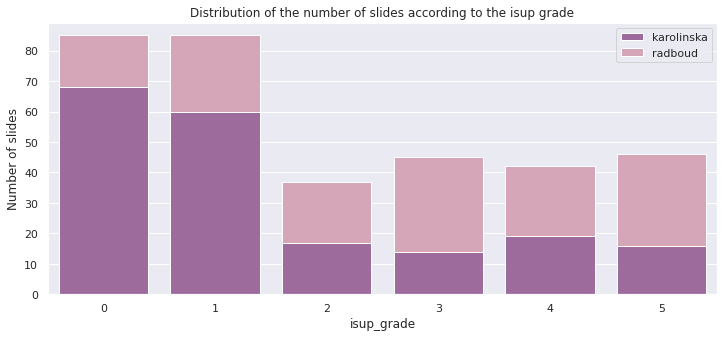

In [6]:
isup_grades_repartition = pd.DataFrame({"isup_grade": [0, 1, 2, 3, 4, 5]})
isup_grades_repartition["karolinska"] = df_train[df_train["data_provider"]=="karolinska"].groupby("isup_grade")\
                                                                        .agg({"image_id": "count"})["image_id"]
isup_grades_repartition["radboud"] = df_train[df_train["data_provider"]=="radboud"].groupby("isup_grade")\
                                                                  .agg({"image_id": "count"})["image_id"]

plt.figure(figsize=(12, 5))
sns.barplot(x="isup_grade", y="karolinska", color="#a563a4", data=isup_grades_repartition, label="karolinska")
sns.barplot(x="isup_grade", y="radboud", color="#dd9eb6", data=isup_grades_repartition, label="radboud",
            bottom=isup_grades_repartition["karolinska"])
plt.ylabel("Number of slides")
plt.title("Distribution of the number of slides according to the isup grade")
plt.legend();

We will work on images: let's display their sizes.

In [7]:
def add_shapes(df, path_imgs):
    df["n_rows"] = None
    df["n_cols"] = None
    for i in tqdm(range(df.shape[0])): # for each index of the dataframe
        row = df.iloc[i] # find the row related to the index
        img_id = row.image_id  # find the slide of the row
        # open the slide
        tiff_file = os.path.join(path_imgs, f"{img_id}.tiff")
        img = skimage.io.MultiImage(tiff_file)[-1]
        # add the shape
        df.loc[i, "n_rows"] = img.shape[0]
        df.loc[i, "n_cols"] = img.shape[1]

add_shapes(df_train, "./train/train")
add_shapes(df_test, "./test/test")

100%|██████████| 86/86 [06:44<00:00,  4.71s/it]


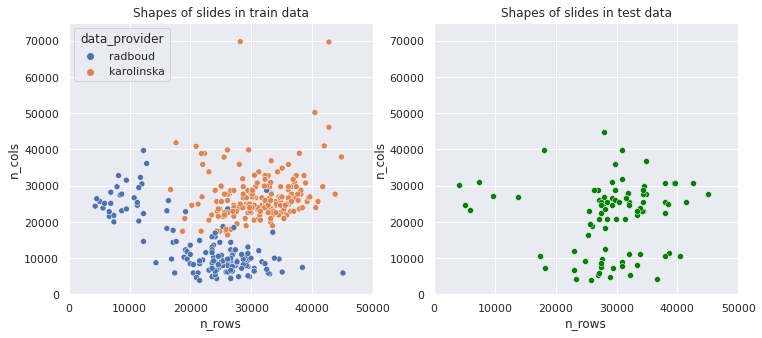

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
sns.scatterplot(data=df_train, x="n_rows", y="n_cols", hue="data_provider")
plt.title("Shapes of slides in train data")
plt.xlim(0, 50000)
plt.ylim(0, 75000)

plt.subplot(122)
sns.scatterplot(data=df_test, x="n_rows", y="n_cols", color="green")
plt.title("Shapes of slides in test data")
plt.xlim(0, 50000)
plt.ylim(0, 75000);

The images are not all the same size at all. As the slides are not all the same form, we must think of a technique to reshape the data. <br>
But first, let's explore the slides a bit more.

# III - <a name="visualization"></a> Visualization of the slides (+ masks)

Let's start by plotting all the slides to have an overview of the data.

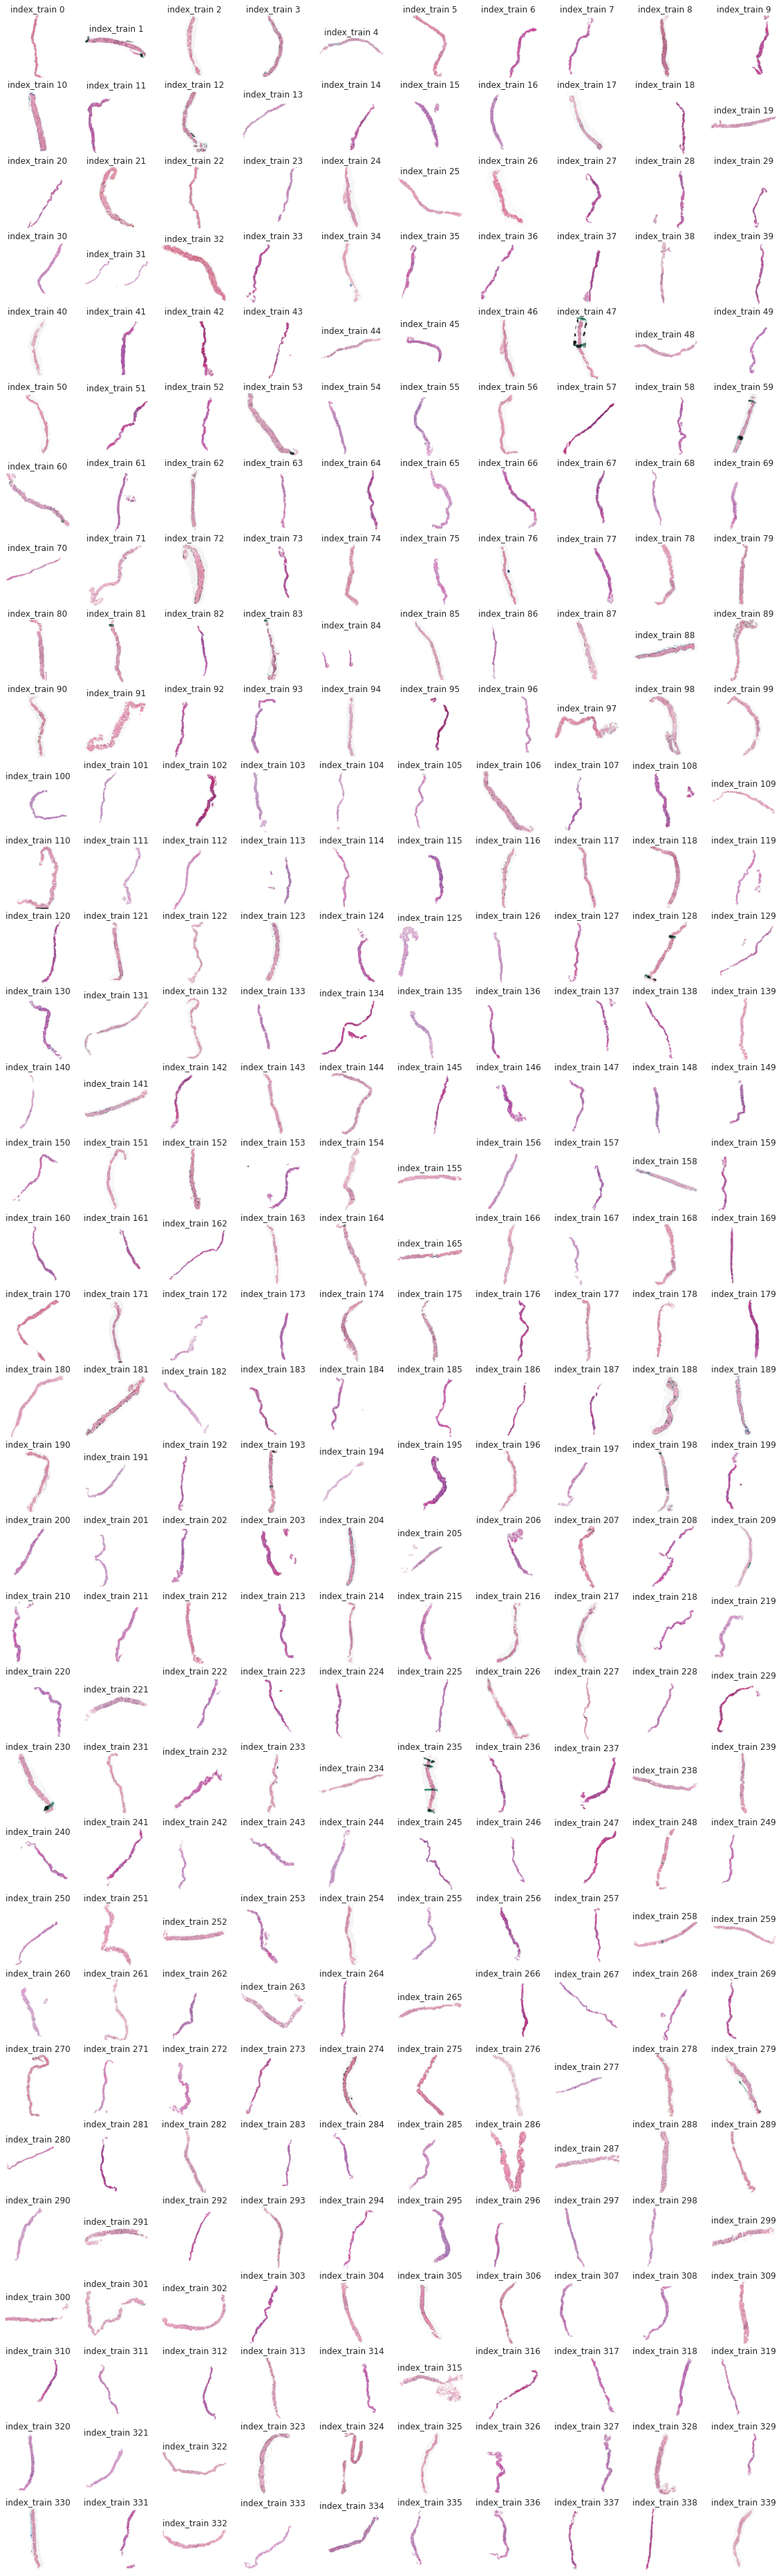

In [9]:
figure, axis = plt.subplots(34, 10, figsize=(20, 68))

for i in range(34):
    for j in range(10):
        row = df_train.iloc[i*10+j]
        img_id = row.image_id    
        tiff_file = os.path.join("./train/train", f"{img_id}.tiff")
        img = cv2.resize(skimage.io.MultiImage(tiff_file)[-1], (0, 0), fx=0.01, fy=0.01)
        axis[i, j].imshow(img)
        axis[i, j].set_title("index_train {}".format(i*10+j))
        axis[i, j].axis("off")

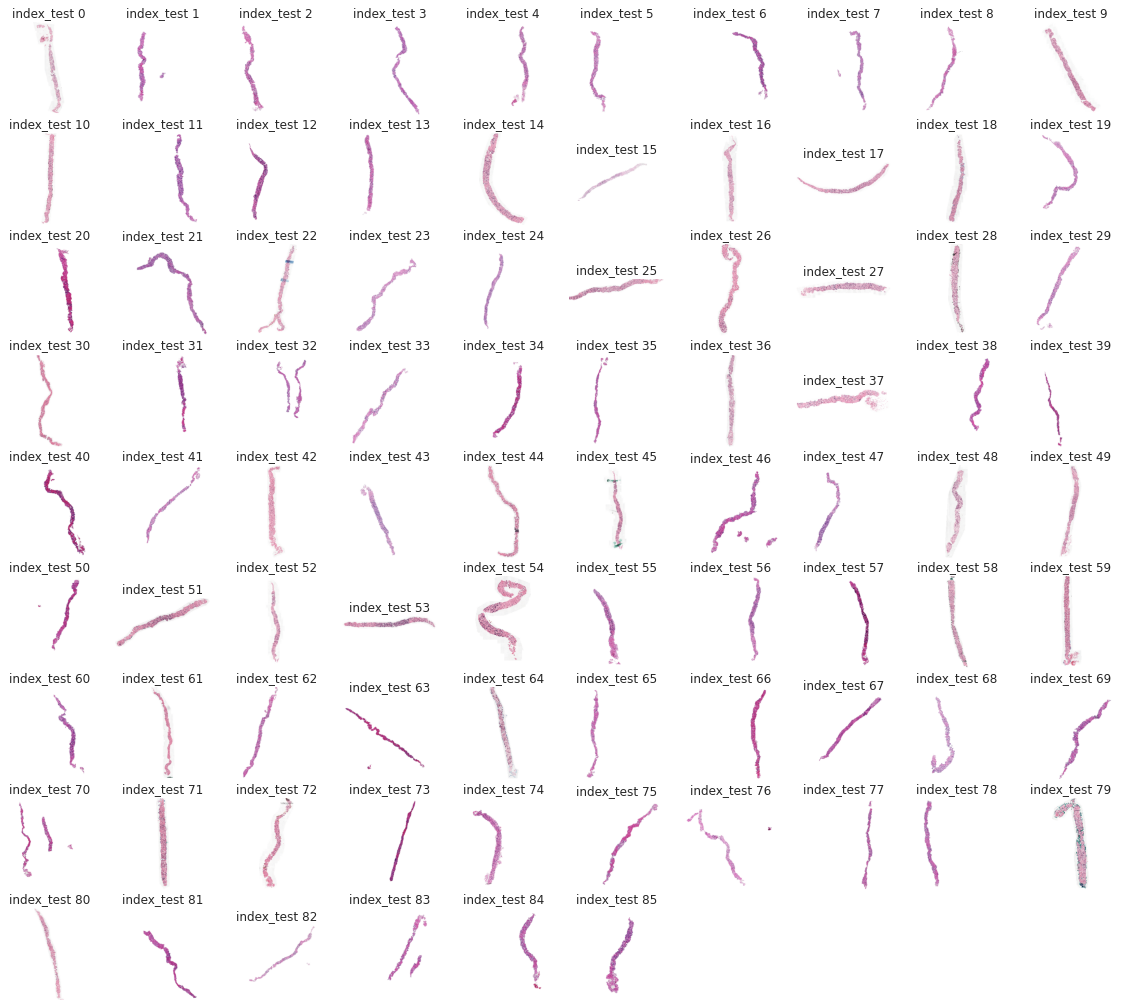

In [10]:
figure, axis = plt.subplots(9, 10, figsize=(20, 18))

for i in range(9):
    for j in range(10):
        if (i==8) and (j in [6, 7, 8, 9, 10]):
             axis[i, j].axis("off")
        else:
            row = df_test.iloc[i*10+j]
            img_id = row.image_id    
            tiff_file = os.path.join("./test/test", f"{img_id}.tiff")
            img = cv2.resize(skimage.io.MultiImage(tiff_file)[-1], (0, 0), fx=0.01, fy=0.01)
            axis[i, j].imshow(img)
            axis[i, j].set_title("index_test {}".format(i*10+j))
            axis[i, j].axis("off")

The images are pink on a white background. We notice that there is sometimes a grayish color around the cutout. It can be interesting to remove the background during the preprocessing.

We know from the previous section that the images are very large. We can display a zoom of one of the slides to see the level of detail.

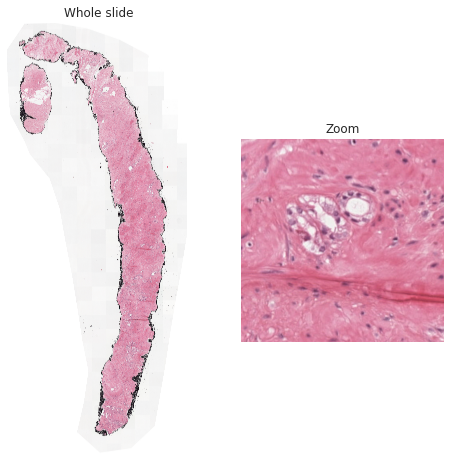

In [11]:
# find a slide to plot with a zoom
img_id = df_train.iloc[72].image_id
tiff_file = os.path.join("./train/train", f"{img_id}.tiff")
img = skimage.io.MultiImage(tiff_file)[-1]

plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.imshow(img)
plt.title("Whole slide")
plt.axis("off")

plt.subplot(122)
plt.imshow(img[10000:10500, 6000:6500])
plt.title("Zoom")
plt.axis("off");

There are masks in the training data. We will not use these for prediction, but they can be interesting to do some visualizations.

In [12]:
filenames = [f.split('.tiff')[0] for f in os.listdir("./train/train/") if f.endswith('.tiff')]

def mask_img(i,max_size=(600,400)):
    slide = openslide.OpenSlide(os.path.join("./train/train", f'{filenames[i]}.tiff'))
    mask =  openslide.OpenSlide(os.path.join("./train_label_masks/train_label_masks", f'{filenames[i]}.tiff'))
    # Here we compute the "pixel spacing": the physical size of a pixel in the image.
    # OpenSlide gives the resolution in centimeters so we convert this to microns.
    f,ax =  plt.subplots(1,2 ,figsize=(13,15))
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    img = slide.get_thumbnail(size=max_size) #IMAGE 

    mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])

    ax[0].imshow(img) 
    ax[1].imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5) #IMAGE MASKS

    ax[0].axis("off")
    ax[1].axis("off")
    ax[0].grid("off")
    ax[1].grid("off")

    image_id = filenames[i]
    data_provider = df_train.set_index('image_id').loc[filenames[i], 'data_provider']
    isup_grade = df_train.set_index('image_id').loc[filenames[i], 'isup_grade']
    gleason_score = df_train.set_index('image_id').loc[filenames[i], 'gleason_score']
    ax[0].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score} IMAGE")
    ax[1].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score} IMAGE_MASK")

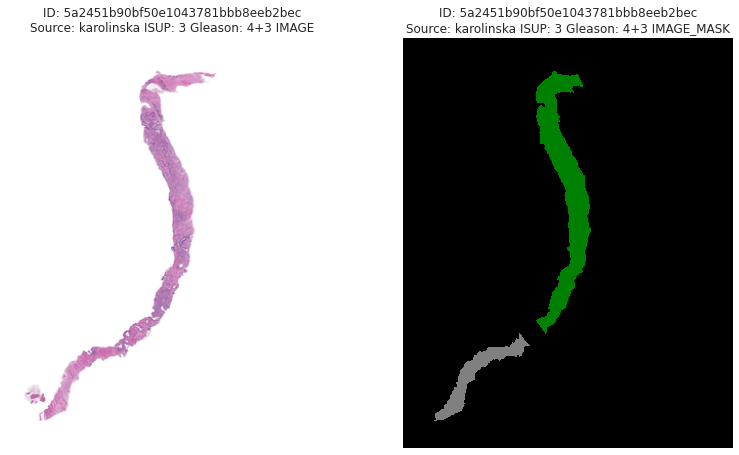

In [13]:
mask_img(0)

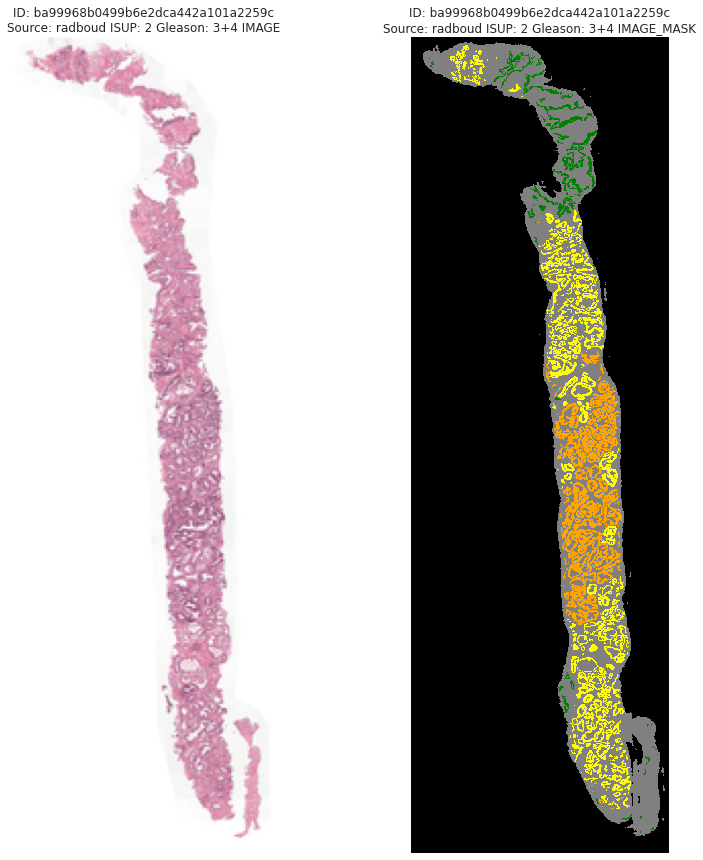

In [14]:
mask_img(10)

We can clearly see the difference between the two providers through their masks.

In [15]:
def differentiate_cancerous(i):
    mask =  openslide.OpenSlide(os.path.join("./train_label_masks/train_label_masks", f'{filenames[i]}.tiff'))
    mask_level = mask.read_region((0,0),mask.level_count - 1,mask.level_dimensions[-1]) #Selecting the level
    mask_data = np.asarray(mask_level)[:,:,0] #SELECTING R from RGB
    
    mask_background = np.where(mask_data == 0, 1, 0).astype(np.uint8) # SELECTING BG
    mask_benign = np.where(mask_data == 1, 1, 0).astype(np.uint8) #SELECTING BENIGN LABELS
    
    if df_train.set_index('image_id').loc[filenames[i],'data_provider'] == 'karolinska':
        mask_cancerous = np.where(mask_data == 2, 1, 0).astype(np.uint8) #SELECTING CANCEROUS LABELS
    elif df_train.set_index('image_id').loc[filenames[i],'data_provider'] == 'radboud':
        mask_cancerous = np.where(mask_data == 3, 1, 0).astype(np.uint8) #SELECTING CANCEROUS LABELS (faire varier le premier chiffre a un impact significatif : ?)
      # mask_cancerous = np.where(mask_data == 2, 1, 0).astype(np.uint8) #SELECTING NON-CANCEROUS LABELS
      # mask_cancerous = np.where(mask_data == 5, 1, 0).astype(np.uint8) #SELECTING NON-CANCEROUS LABELS

    fig, ax = plt.subplots(1, 3, figsize=(18, 12))

    ax[0].imshow(mask_background.astype(float), cmap=plt.cm.gray)
    ax[0].axis('off')
    ax[0].set_title('background, data_provider:'+df_train.set_index('image_id').loc[filenames[i]]["data_provider"]);
    ax[1].imshow(mask_benign.astype(float), cmap=plt.cm.gray)
    ax[1].axis('off')
    ax[1].set_title('benign');
    ax[2].imshow(mask_cancerous.astype(float), cmap=plt.cm.gray)
    ax[2].axis('off')
    ax[2].set_title('cancerous')

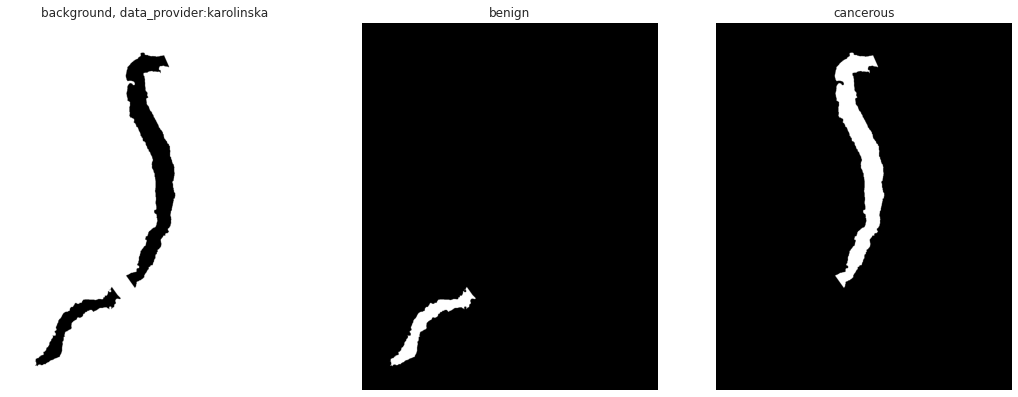

In [16]:
differentiate_cancerous(0)

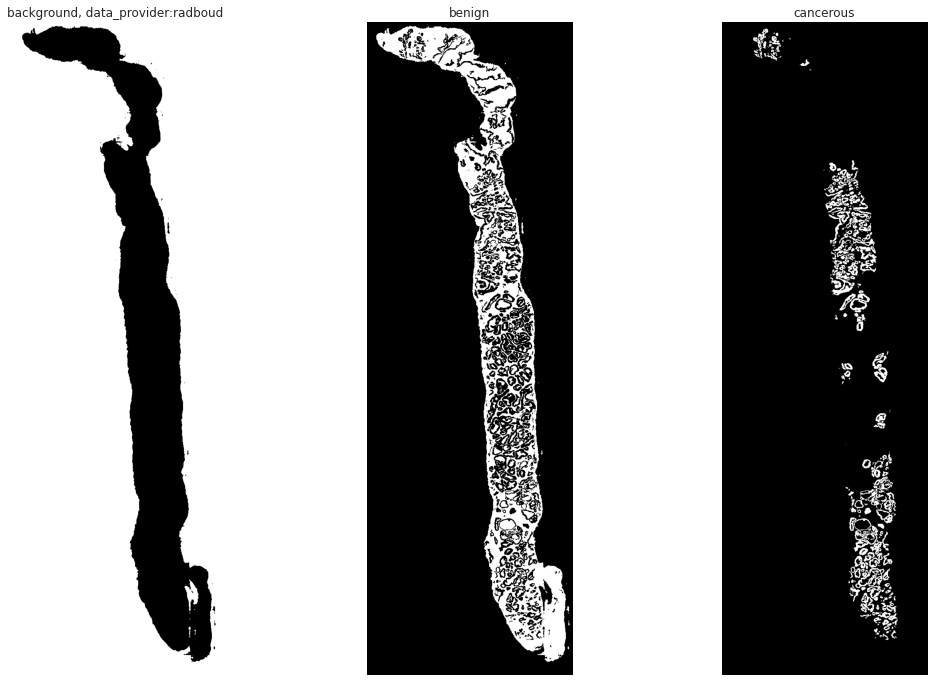

In [17]:
differentiate_cancerous(10)

# IV - <a name="preprocessing"></a> Explanation of the image preprocessing pipeline

From the previous parts, we have identified two things:
> - The slides are not all the same size, and none of them is square (which we would need to use a deep learning model).
>
>
> - The interesting part of each slide occupies a very small proportion of the overall image.

some research allowed us to find the following notebook: https://www.kaggle.com/code/iafoss/panda-16x128x128-tiles <br>
Nous allons utiliser et adapter cette base pour notre preprocessing.

## A - <a name="background"></a> Background removal

Removing the background will allow us to know how many pixels represent tissue, and thus to adapt the size of our tiles to each image.

It is very easy to remove the background from the slides: just remove the areas where the average of the three pixels exceeds a certain value (light gray / white). <br>
Here is an example on two images of the dataset.

In [18]:
# Find two images for example plots
img_id = df_train.iloc[46].image_id
tiff_file = os.path.join("./train/train", f"{img_id}.tiff")
img1 = skimage.io.MultiImage(tiff_file)[-1]

img_id = df_train.iloc[72].image_id
tiff_file = os.path.join("./train/train", f"{img_id}.tiff")
img2 = skimage.io.MultiImage(tiff_file)[-1]

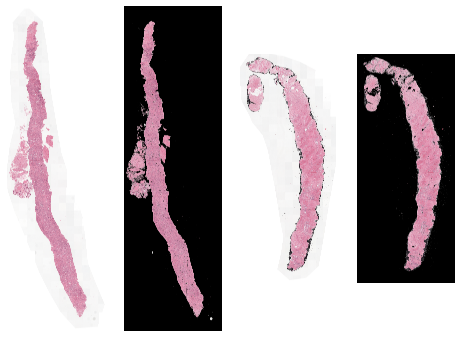

In [19]:
plt.figure(figsize=(8, 8))

# plot first image
plt.subplot(141)
plt.imshow(img1)
plt.axis("off")

# remove the background of the first image and plot it
img1[img1.mean(axis=-1)>=235] = 0
plt.subplot(142)
plt.imshow(img1)
plt.axis("off")

# plot second image
plt.subplot(143)
plt.imshow(img2)
plt.axis("off")

# remove the background of the second image and plot it
img2[img2.mean(axis=-1)>=235] = 0
plt.subplot(144)
plt.imshow(img2)
plt.axis("off");

## B - <a name="selection"></a> Tile selection

We use the tiles selection method seen in the kaggle notebook.

In [20]:
def get_tiles(img, tile_size, n_tiles):
    # find by how much we must pad the image so that the image dims are multiples of tile_size
    h, w, c = img.shape
    pad_h = (tile_size - h % tile_size) % tile_size
    pad_w = (tile_size - w % tile_size) % tile_size
    # pad the image with constant values (255)
    img = np.pad(img, [[pad_h//2, pad_h - pad_h//2], [pad_w//2, pad_w - pad_w//2], [0, 0]],
                 constant_values=0)
    # reshape the image and swap the order of the dims
    img = img.reshape(img.shape[0]//tile_size, tile_size, img.shape[1]//tile_size, tile_size, 3)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, tile_size, tile_size, 3)
    # if the image has less tiles than n_tiles we pad
    if len(img) < n_tiles:
        img = np.pad(img,[[0, n_tiles - len(img)], [0, 0], [0, 0], [0, 0]], constant_values=0)   
    # select the tiles with the most tissue
    idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[-n_tiles:]
    tiles = img[idxs]
    return tiles

In [21]:
def concat_tiles(tiles, tile_shape):
    image = cv2.hconcat([cv2.vconcat(tiles[ts]) for ts in tile_shape])
    return image

In [22]:
tile_shape = np.array(range(100)).reshape((10, 10))

## C - <a name="test"></a> Test of the pipeline

To see if our technique works, we will apply it to the biggest and smallest slides. The goal is to resize the slides while keeping a maximum of tissue, and a minimum of empty space.

We will create `10*10`` tiles for each slide.
> Note that we use a particular tile size for each image. We count the number of non-zero pixels of the slide without background with `(img!=0).sum()`, then we take its square root and divide by a certain factor (we tested several factors, and 14 seems to give good results).

### 1 - <a name="small"></a> Smallest slide

In [23]:
img_id = df_train[df_train["n_cols"]==df_train["n_cols"].min()].image_id.values[0]
tiff_file = os.path.join("./train/train", f"{img_id}.tiff")
img = skimage.io.MultiImage(tiff_file)[-1]

img[img.mean(axis=-1)>=235] = 0
tiles = get_tiles(img, int(np.sqrt((img!=0).sum())/14), 100)
img_tiles = concat_tiles(tiles, tile_shape)

In [24]:
img.shape

(21504, 3840, 3)

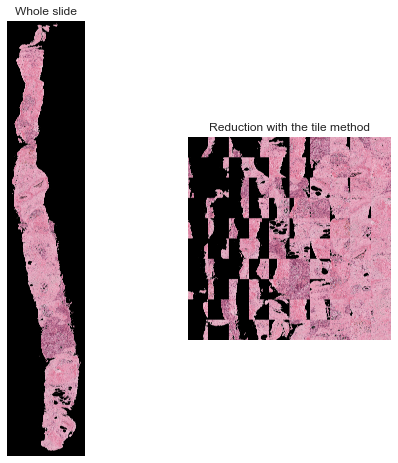

In [25]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.imshow(img)
plt.title("Whole slide")
plt.axis("off")

plt.subplot(122)
plt.imshow(img_tiles)
plt.title("Reduction with the tile method")
plt.axis("off");

In [26]:
print("Proportion of tissue retained in the reduced image: {}%"\
              .format(round(((img_tiles!=0).sum()) / ((img!=0).sum())*100)))

Proportion of tissue retained in the reduced image: 99%


### 1 - <a name="big"></a> Biggest slide

In [27]:
img_id = df_train[df_train["n_cols"]==df_train["n_cols"].max()].image_id.values[0]
tiff_file = os.path.join("./train/train", f"{img_id}.tiff")
img = skimage.io.MultiImage(tiff_file)[-1]

img[img.mean(axis=-1)>=235] = 0
tiles = get_tiles(img, int(np.sqrt((img!=0).sum())/14), 100)
img_tiles = concat_tiles(tiles, tile_shape)

In [28]:
img.shape

(28180, 69719, 3)

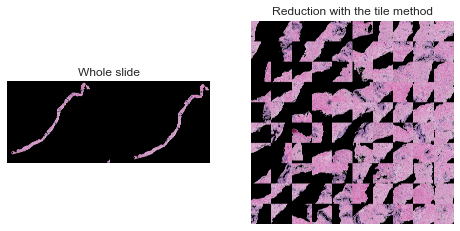

In [29]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.imshow(img)
plt.title("Whole slide")
plt.axis("off")

plt.subplot(122)
plt.imshow(img_tiles)
plt.title("Reduction with the tile method")
plt.axis("off");

In [30]:
print("Proportion of tissue retained in the reduced image: {}%"\
              .format(round(((img_tiles!=0).sum()) / ((img!=0).sum())*100)))

Proportion of tissue retained in the reduced image: 91%


Our technique seems to work well: we resize each image into a square, keeping most of the tissue and eliminating most of the background. 

We apply this pipeline in the next code file (part 2). <br>
The only thing we add is a resizing of the output tiles so that all processed images have the same size.